# Import Libraries

In [10]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Download Data

In [9]:
(X_TRAIN,Y_TRAIN),(X_TEST,Y_TEST)=tf.keras.datasets.mnist.load_data()

# Plot Examples

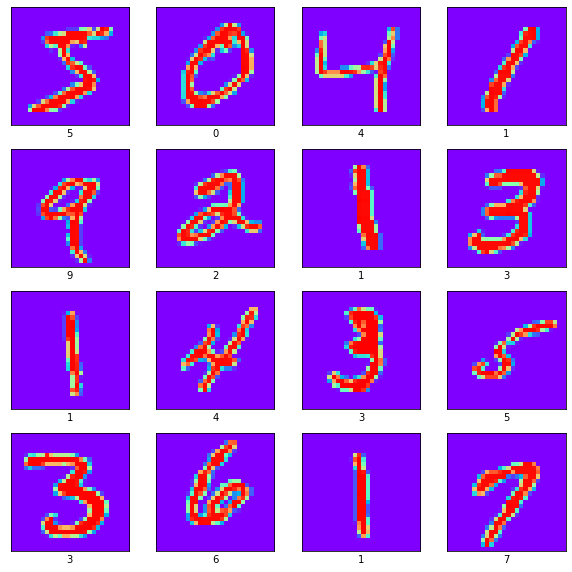

In [19]:
plt.figure(figsize=(10,10))

for i in range(0,16):
    plt.subplot(4,4,i+1)
    plt.imshow(X_TRAIN[i],cmap = 'rainbow')
    plt.xlabel(str(Y_TRAIN[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

# Normalize Data

In [22]:
X_TRAIN = np.reshape(X_TRAIN,(60000, 28*28))
X_TEST = np.reshape(X_TEST,(10000,28*28))

In [23]:
X_TRAIN[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18,
       126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 17

In [24]:
X_TRAIN = X_TRAIN/255.
X_TEST = X_TEST/255.


# Create a Neural Network Model

In [27]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32,activation='sigmoid', input_shape=(784,)),
    tf.keras.layers.Dense(32,activation='sigmoid'),
    tf.keras.layers.Dense(10,activation='softmax'),
    
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy']
    
)

# Train the Model

In [30]:
_ = model.fit(
    X_TRAIN,Y_TRAIN,
    validation_data= (X_TEST,Y_TEST),
    epochs = 20, batch_size = 1024,
    verbose = 2
)

Epoch 1/20
59/59 - 0s - loss: 0.3822 - accuracy: 0.9078 - val_loss: 0.3663 - val_accuracy: 0.9105
Epoch 2/20
59/59 - 0s - loss: 0.3532 - accuracy: 0.9128 - val_loss: 0.3420 - val_accuracy: 0.9131
Epoch 3/20
59/59 - 0s - loss: 0.3295 - accuracy: 0.9174 - val_loss: 0.3222 - val_accuracy: 0.9168
Epoch 4/20
59/59 - 0s - loss: 0.3103 - accuracy: 0.9204 - val_loss: 0.3056 - val_accuracy: 0.9193
Epoch 5/20
59/59 - 0s - loss: 0.2936 - accuracy: 0.9237 - val_loss: 0.2919 - val_accuracy: 0.9214
Epoch 6/20
59/59 - 0s - loss: 0.2795 - accuracy: 0.9266 - val_loss: 0.2793 - val_accuracy: 0.9240
Epoch 7/20
59/59 - 0s - loss: 0.2666 - accuracy: 0.9297 - val_loss: 0.2687 - val_accuracy: 0.9258
Epoch 8/20
59/59 - 0s - loss: 0.2558 - accuracy: 0.9316 - val_loss: 0.2581 - val_accuracy: 0.9280
Epoch 9/20
59/59 - 0s - loss: 0.2455 - accuracy: 0.9348 - val_loss: 0.2489 - val_accuracy: 0.9310
Epoch 10/20
59/59 - 0s - loss: 0.2364 - accuracy: 0.9366 - val_loss: 0.2409 - val_accuracy: 0.9327
Epoch 11/20
59/59 -

# Save the Model

In [31]:
model.save('model.h5')

# ML Server

In [15]:
%%writefile ml_server.py

import json
import tensorflow as tf
import numpy as np
import random
from flask import Flask, request

app = Flask(__name__)

model = tf.keras.models.load_model('model.h5')
feature_model = tf.keras.models.Model(
    model.inputs,
   [layer.output for layer in  model.layers]
)

_,(x_test,_) = tf.keras.datasets.mnist.load_data()
x_test = x_test / 255

def get_prediction():
    index = np.random.choice(x_test.shape[0])
    image = x_test[index,:,:]
    image_arr = np.reshape(image,(1,784))
    return Feature.model.predict(image_arr),image

@app.route('/',methods=['GET','POST'])
def index():
    if request.method=="POST":
        preds,image = get_prediction()
        final_preds = [p.tolist() for p in preds]
        return json.dumps({
            ' prediction': final_preds,
            'image':image.tolist()
        })
    return 'WELCOME TO MODEL SERVER'
    
if __name__ == '__main__':
    app.run()





Overwriting ml_server.py


# Streamlit Web App

In [22]:
%%writefile app.py

import streamlit as st
import json
import requests
import matplotlib.pyplot as plt
import numpy as np

URL = 'http://127.0.0.1:5000'

st.title('neural network visuliser')
st.sidebar.markdown("input image")

if st.button('Get random prediction'):
    response = requests.post(URL, data={})
    response = json.loads(response.text)
    preds = response.get('prediction')
    image = response.get('image')
    image = np.reshape(image, (28, 28))
    
    st.sidebar.image(image,width=150)
    
    for layer, p in enumerate(preds):
        
        numbers = np.squeeze(np.array(p))
        
        plt.figure(figsize=(32,4))
        
        if layer == 2:
            row = 1
            col = 10
        else:
            row = 2
            col = 10
            
        for i, number in enumerate(numbers):
            plt.subplot(row,col,i+1)
            plt.imshow(number * np.ones((8,8,3)).astype('float32'))
            plt.xticks([])
            plt.yticks([])
            
            if layer == 2:
                plt.xlabel(str(i), fontsize=40)
        plt.subplots_adjust(wspace = 0.05, hspace = 0.05)
        plt.tight_layout()
        st.text('Layer {}'.format(i+1))
        st.pyplot()
        
    

Overwriting app.py
